<a href="https://colab.research.google.com/github/kerserbibk/ltsm-stock-forecast-/blob/main/stock_forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import io
import os
from google.colab import files

In [2]:
look_back = 45 # best at 30-45
layer_size = 50
lr = 0.006
epochs = 200
num_layers = 1

In [3]:
df = pd.read_csv('stocks.csv')

df.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Brand_Name,Ticker,Industry_Tag,Country,Capital Gains
0,2025-05-05 00:00:00-04:00,6.730000,7.140000,6.590000,6.890000,16916400.0,0.0,0.0,peloton,PTON,fitness,usa,NaN
1,2025-05-05 00:00:00-04:00,99.000000,102.050003,98.760002,100.589996,41181000.0,0.0,0.0,amd,AMD,technology,usa,NaN
2,2025-05-05 00:00:00-04:00,118.389999,118.540001,116.650002,117.199997,47600.0,0.0,0.0,adidas,ADDYY,apparel,germany,NaN
3,2025-05-05 00:00:00-04:00,275.459991,281.589996,274.079987,278.029999,2416300.0,0.0,0.0,american express,AXP,finance,usa,NaN
4,2025-05-05 00:00:00-04:00,27.278000,27.278000,27.278000,27.278000,100.0,0.0,0.0,puma,PMMAF,apparel,germany,NaN


In [4]:
df = df[['Date','Close','Ticker']]
df.head()

,Date,Close,Ticker
0,2025-05-05 00:00:00-04:00,6.890000,PTON
1,2025-05-05 00:00:00-04:00,100.589996,AMD
2,2025-05-05 00:00:00-04:00,117.199997,ADDYY
3,2025-05-05 00:00:00-04:00,278.029999,AXP
4,2025-05-05 00:00:00-04:00,27.278000,PMMAF


In [5]:
#converting string to datetime
import datetime as dt
df['Date'] = pd.to_datetime(df['Date'])
df.head()

<ipython-input-5-6e0c9924a719>:3: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  df['Date'] = pd.to_datetime(df['Date'])


,Date,Close,Ticker
0,2025-05-05 00:00:00-04:00,6.890000,PTON
1,2025-05-05 00:00:00-04:00,100.589996,AMD
2,2025-05-05 00:00:00-04:00,117.199997,ADDYY
3,2025-05-05 00:00:00-04:00,278.029999,AXP
4,2025-05-05 00:00:00-04:00,27.278000,PMMAF


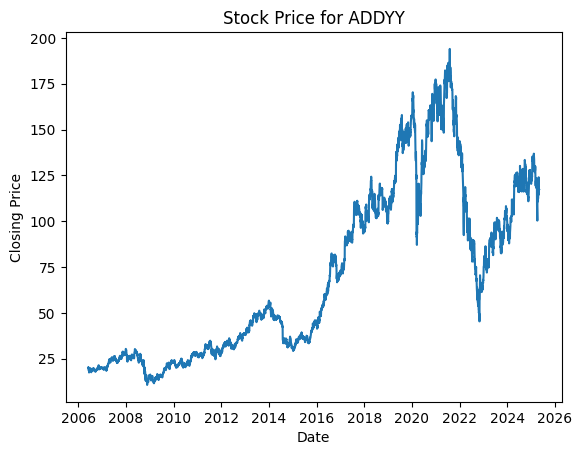

In [6]:
# --- Filter data for the specific ticker ---
ticker_to_plot = 'ADDYY'  # Replace with the desired ticker symbol
filtered_df = df[df['Ticker'] == ticker_to_plot]

# --- Plot the data for the filtered ticker ---
plt.plot(filtered_df['Date'], filtered_df['Close'])
plt.title(f'Stock Price for {ticker_to_plot}')  # Add a title to the plot
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.show()

In [7]:
def create_dataset(data, lookback=look_back):
    X, y = [], []
    for i in range(lookback, len(data)):
        X.append(data[i-lookback:i, 0])
        y.append(data[i, 0])  # next day
    return np.array(X), np.array(y)

# 'Close'
close_prices = filtered_df[['Close']].values

# normalization(0,1)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_prices = scaler.fit_transform(close_prices)

# X and y
X, y = create_dataset(close_prices, lookback=look_back)

X.shape

(4766, 45)

In [8]:
# turning data to 3d shape
X_reshaped = np.reshape(X, (X.shape[0], X.shape[1], 1))

# to tensor
X_tensor = torch.Tensor(X_reshaped)
y_tensor = torch.Tensor(y)

# splitting train test
train_size = int(len(X_tensor) * 0.8)
X_train_tensor, X_test_tensor = X_tensor[:train_size], X_tensor[train_size:]
y_train_tensor, y_test_tensor = y_tensor[:train_size], y_tensor[train_size:]

In [9]:
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=layer_size, output_size=1):
        super(LSTMModel, self).__init__()

        # LSTM layer
        self.lstm = nn.LSTM(input_size, hidden_layer_size, num_layers=num_layers ,batch_first=True)

        # output layer (Dense layer)
        self.linear = nn.Linear(hidden_layer_size, output_size)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)

        predictions = self.linear(lstm_out[:, -1, :])

        return predictions

# define model
model = LSTMModel(input_size=1, hidden_layer_size=layer_size, output_size=1)

# define loss
criterion = nn.MSELoss()

# define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [10]:
#train
for epoch in range(epochs):
    model.train()

    optimizer.zero_grad()
    y_pred = model(X_train_tensor)

    # calculate loss
    loss = criterion(y_pred, y_train_tensor.view(-1, 1))

    # backpropogation
    loss.backward()
    optimizer.step()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")

Epoch 1/200, Loss: 8911.9971
Epoch 2/200, Loss: 8882.2598
Epoch 3/200, Loss: 8854.7334
Epoch 4/200, Loss: 8830.8438
Epoch 5/200, Loss: 8806.3760
Epoch 6/200, Loss: 8779.0088
Epoch 7/200, Loss: 8748.8721
Epoch 8/200, Loss: 8718.6943
Epoch 9/200, Loss: 8688.6045
Epoch 10/200, Loss: 8656.5801
Epoch 11/200, Loss: 8622.4590
Epoch 12/200, Loss: 8586.6504
Epoch 13/200, Loss: 8550.7939
Epoch 14/200, Loss: 8513.8281
Epoch 15/200, Loss: 8473.8291
Epoch 16/200, Loss: 8427.4131
Epoch 17/200, Loss: 8371.6211
Epoch 18/200, Loss: 8309.5732
Epoch 19/200, Loss: 8247.4023
Epoch 20/200, Loss: 8191.4292
Epoch 21/200, Loss: 8142.3672
Epoch 22/200, Loss: 8097.6855
Epoch 23/200, Loss: 8057.3804
Epoch 24/200, Loss: 8018.6997
Epoch 25/200, Loss: 7982.4839
Epoch 26/200, Loss: 7948.5591
Epoch 27/200, Loss: 7915.4194
Epoch 28/200, Loss: 7881.7334
Epoch 29/200, Loss: 7846.4658
Epoch 30/200, Loss: 7807.7261
Epoch 31/200, Loss: 7764.1763
Epoch 32/200, Loss: 7721.6890
Epoch 33/200, Loss: 7685.7598
Epoch 34/200, Loss:

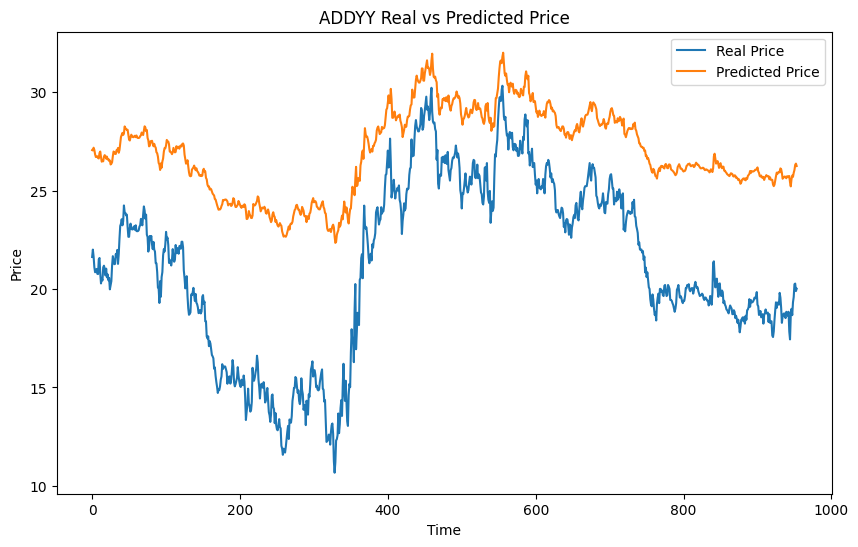

In [11]:
model.eval()

# Prediction
with torch.no_grad():
    predictions = model(X_test_tensor)

# Visualize
plt.figure(figsize=(10,6))
plt.plot(y_test_tensor.numpy(), label='Real Price')
plt.plot(predictions.numpy(), label='Predicted Price')
plt.title(f'{ticker_to_plot} Real vs Predicted Price')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [12]:
last_lookback_days = X_test_tensor[-1].unsqueeze(0)

with torch.no_grad():
    next_day_prediction = model(last_lookback_days)

# normalize predictoin
next_day_prediction = scaler.inverse_transform(next_day_prediction.numpy())

# decide which
last_day_price = close_prices[-1]
if next_day_prediction[0][0] > last_day_price[0]:
    print("Predict: Increase")
else:
    print("Predict: Decrease")

Predict: Increase
